# Model Evaluation

In this notebook, we evaluate the most effective feature sets identified through previous feature selection and dimensionality reduction analyses across different classification models.  

Before training, we normalize the features to ensure that all variables contribute equally to the learning process. Since different features may have varying scales, normalization prevents models from being biased toward features with larger numerical values.

To ensure a robust assessment, we implement cross-validation and evaluate model performance using multiple metrics. This approach allows us to compare different classifiers, analyze how well each feature set generalizes, and determine the most suitable combinations for epileptic seizure detection.

## Training and Evaluation Pipeline  

In the following code cell, we define the object-oriented pipeline for training and evaluating the classification models. This approach ensures a modular and reusable structure, making it easier to experiment with different models and configurations.  

If you are only interested in the results, we suggest skipping to the final sections, where we present the model evaluations and comparisons.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # LDA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    make_scorer
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector  # NEW for sequential selection



data_path = 'transformed_df.csv'
target_column = 'y'



class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a subset of columns (features) from a pandas DataFrame.
    """
    def __init__(self, feature_names):
        """
        Parameters:
            feature_names (list): List of column names to select.
        """
        self.feature_names = feature_names

    def fit(self, X, y=None):
        # Validate that the provided feature names exist in X
        missing = [f for f in self.feature_names if f not in X.columns]
        if missing:
            raise ValueError("The following features are missing in the data: " + str(missing))
        return self

    def transform(self, X):
        return X[self.feature_names]




class TrainingPipeline:
    """
    A configurable training pipeline that loads data, preprocesses features (using either
    naive feature selection, sequential feature selection, or dimensionality reduction),
    trains a classifier using cross‑validation, and evaluates performance under multiple metrics.
    """
    def __init__(
        self,
        data_path,
        target_column,
        scaling=True,
        feature_selection_method=None,  # Options: 'naive' or 'sequential'
        feature_list=None,              # Required if feature_selection_method == 'naive'
        sfs_params=None,                # Required if feature_selection_method == 'sequential'
        reduction_method=None,          # Options: 'pca' or 'lda'
        reduction_params=None,
        classifier_name='gnb',          # Options: 'gnb' or 'svm'
        classifier_params=None,
        cv_splits=5,
        scoring_metrics=None,
        random_state=42
    ):
        """
        Parameters:
            data_path (str): Path to the CSV file.
            target_column (str): Name of the target column.
            scaling (bool): Whether to scale the data.
            feature_selection_method (str or None): If set, can be 'naive' for using a predefined
                feature list or 'sequential' to perform sequential feature selection.
            feature_list (list or None): List of feature names (required if feature_selection_method=='naive').
            sfs_params (dict or None): Parameters for SequentialFeatureSelector (required if
                feature_selection_method=='sequential'). For example:
                {'n_features_to_select': 5, 'direction': 'forward', 'cv': 3}
            reduction_method (str or None): Either 'pca' or 'lda' if you want to perform dimensionality
                reduction. Should be mutually exclusive with feature_selection_method.
            reduction_params (dict or None): Parameters to pass to the dimensionality reduction object.
            classifier_name (str): 'gnb' for GaussianNB or 'svm' for SVC.
            classifier_params (dict or None): Dictionary with classifier hyperparameters.
            cv_splits (int): Number of cross-validation splits.
            scoring_metrics (dict or None): Dictionary of scoring functions.
            random_state (int): Random seed.
        """
        self.data_path = data_path
        self.target_column = target_column
        self.scaling = scaling
        self.feature_selection_method = feature_selection_method
        self.feature_list = feature_list
        self.sfs_params = sfs_params or {}
        self.reduction_method = reduction_method
        self.reduction_params = reduction_params or {}
        self.classifier_name = classifier_name
        self.classifier_params = classifier_params or {}
        self.cv_splits = cv_splits
        # Default scoring: accuracy, precision, recall, and F1 (macro averaged)
        self.scoring_metrics = scoring_metrics or {
            'accuracy': 'accuracy',
            'precision': make_scorer(precision_score, average='weighted'),
            'recall': make_scorer(recall_score, average='weighted'),
            'f1': make_scorer(f1_score, average='weighted')
        }
        self.random_state = random_state

        self.pipeline = None  # This will hold the scikit-learn Pipeline
        self.data = None
        self.X = None
        self.y = None

    def load_data(self):
        """Loads data from the CSV file and splits it into features and target."""
        self.data = pd.read_csv(self.data_path)
        self.X = self.data.drop(columns=[self.target_column])
        self.y = self.data[self.target_column]

    def build_pipeline(self):
        """
        Constructs the scikit-learn Pipeline based on the configuration.

        The steps are chosen according to the following mutually exclusive options:
            - Naive feature selection (using a predefined feature list).
            - Sequential feature selection (using SequentialFeatureSelector).
            - Dimensionality reduction (using PCA or LDA).
            - (If none of the above are provided, only scaling is applied if enabled.)
        Followed by the classifier.
        """
        steps = []

        # Prevent mixing feature selection with dimensionality reduction in this pipeline.
        if self.feature_selection_method is not None and self.reduction_method is not None:
            raise ValueError("Cannot use both feature_selection_method and reduction_method simultaneously.")

        # CASE 1: Naive Feature Selection
        if self.feature_selection_method == 'naive':
            if not self.feature_list:
                raise ValueError("feature_list must be provided when using naive feature selection.")
            steps.append(('feature_selector', FeatureSelector(self.feature_list)))
            if self.scaling:
                steps.append(('scaler', StandardScaler()))

        # CASE 2: Sequential Feature Selection
        elif self.feature_selection_method == 'sequential':
            # For sequential feature selection, scaling is typically recommended first.
            if self.scaling:
                steps.append(('scaler', StandardScaler()))
            if not self.sfs_params:
                raise ValueError("sfs_params must be provided for sequential feature selection.")
            # Use a clone of the final classifier as the estimator for SFS.
            classifier_name = self.classifier_name.lower()
            if classifier_name == 'gnb':
                base_estimator = GaussianNB(**self.classifier_params)
            elif classifier_name == 'svm':
                base_estimator = SVC(**self.classifier_params)
            else:
                raise ValueError("Unsupported classifier for sequential feature selection: " + self.classifier_name)
            steps.append(('sequential_selector', SequentialFeatureSelector(base_estimator, **self.sfs_params)))

        # CASE 3: Dimensionality Reduction
        elif self.reduction_method is not None:
            if self.scaling:
                steps.append(('scaler', StandardScaler()))
            method = self.reduction_method.lower()
            if method == 'pca':
                steps.append(('pca', PCA(**self.reduction_params)))
            elif method == 'lda':
                steps.append(('lda', LinearDiscriminantAnalysis(**self.reduction_params)))
            else:
                raise ValueError("Unsupported reduction method: " + self.reduction_method)

        # CASE 4: No explicit feature selection or reduction (just scaling if enabled)
        else:
            if self.scaling:
                steps.append(('scaler', StandardScaler()))

        # Instantiate the final classifier
        classifier_name = self.classifier_name.lower()
        if classifier_name == 'gnb':
            classifier = GaussianNB(**self.classifier_params)
        elif classifier_name == 'svm':
            classifier = SVC(**self.classifier_params)
        else:
            raise ValueError("Unsupported classifier: " + self.classifier_name)
        steps.append(('classifier', classifier))

        self.pipeline = Pipeline(steps)
    
    def optimize_hyperparameters(self, param_grid, scoring='accuracy', n_jobs=-1):
        """
        Performs hyperparameter optimization using GridSearchCV on the built pipeline.

        Parameters:
            param_grid (dict): Dictionary defining the grid of parameters to search.
            scoring (str or callable): Scoring function to use.
            n_jobs (int): Number of jobs to run in parallel.

        Returns:
            grid_search (GridSearchCV): The fitted GridSearchCV instance.
        """
        # Ensure data is loaded and the pipeline is built.
        if self.data is None:
            self.load_data()
        if self.pipeline is None:
            self.build_pipeline()

        cv = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        grid_search = GridSearchCV(
            self.pipeline,
            param_grid,
            cv=cv,
            scoring=scoring,
            n_jobs=n_jobs
        )
        grid_search.fit(self.X, self.y)
        print("Best parameters found:", grid_search.best_params_)
        print("Best cross-validation {}: {:.4f}".format(scoring, grid_search.best_score_))
        # Optionally, update the pipeline to the best estimator.
        self.pipeline = grid_search.best_estimator_
        return grid_search

    def evaluate_model(self):
        """
        Evaluates the pipeline using cross-validation.

        Returns:
            dict: Cross-validation results for each scoring metric.
        """
        cv = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        results = cross_validate(
            self.pipeline,
            self.X,
            self.y,
            cv=cv,
            scoring=self.scoring_metrics,
            return_train_score=True,
            return_estimator=True
        )
        return results

    def run(self):
        """Runs the complete pipeline: loads data, builds the pipeline, and evaluates the model."""
        self.load_data()
        self.build_pipeline()
        results = self.evaluate_model()
        return results

## Results

Our analysis aims to compare the impact of three key factors on classification performance:  

- When applying Principal Component Analysis (PCA), the influence of the number of retained dimensions.  
- The choice of model, specifically comparing Support Vector Machines (SVM) with and RBF kernel and Naive Bayes.  
- The effect of different feature sets on model performance.  

### Impact of PCA Dimension

In [ ]:
# WITH BAYES
df_bayes = pd.DataFrame()

for pca_dim in range(2,25):
    
    config_pca = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     
    'feature_list': None,                   
    'reduction_method': 'pca',              
    'reduction_params': {'n_components': pca_dim}, 
    'classifier_name': 'gnb',
    #'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
    }

    pipeline_pca = TrainingPipeline(**config_pca)
    results_pca = pipeline_pca.run()

    print("=== PCA Results ===")
    for key, value in results_pca.items():
        if key == "estimator":
            continue
        print(f"{key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})")
    results_pca["pca dimension"]=pca_dim

    df_bayes = pd.concat([df_bayes,pd.DataFrame(results_pca).drop(columns=["fit_time","score_time"])],axis=0)

# WITH SVM
df_svm = pd.DataFrame()

for pca_dim in range(2,25):
    
    config_pca = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     
    'feature_list': None,                   
    'reduction_method': 'pca',              
    'reduction_params': {'n_components': pca_dim}, 
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
    }

    pipeline_pca = TrainingPipeline(**config_pca)
    results_pca = pipeline_pca.run()

    print("=== PCA Results ===")
    for key, value in results_pca.items():
        if key == "estimator":
            continue
        print(f"{key}: {np.mean(value):.4f} (+/- {np.std(value):.4f})")
    results_pca["pca dimension"]=pca_dim

    df_svm = pd.concat([df_svm,pd.DataFrame(results_pca).drop(columns=["fit_time","score_time"])],axis=0)

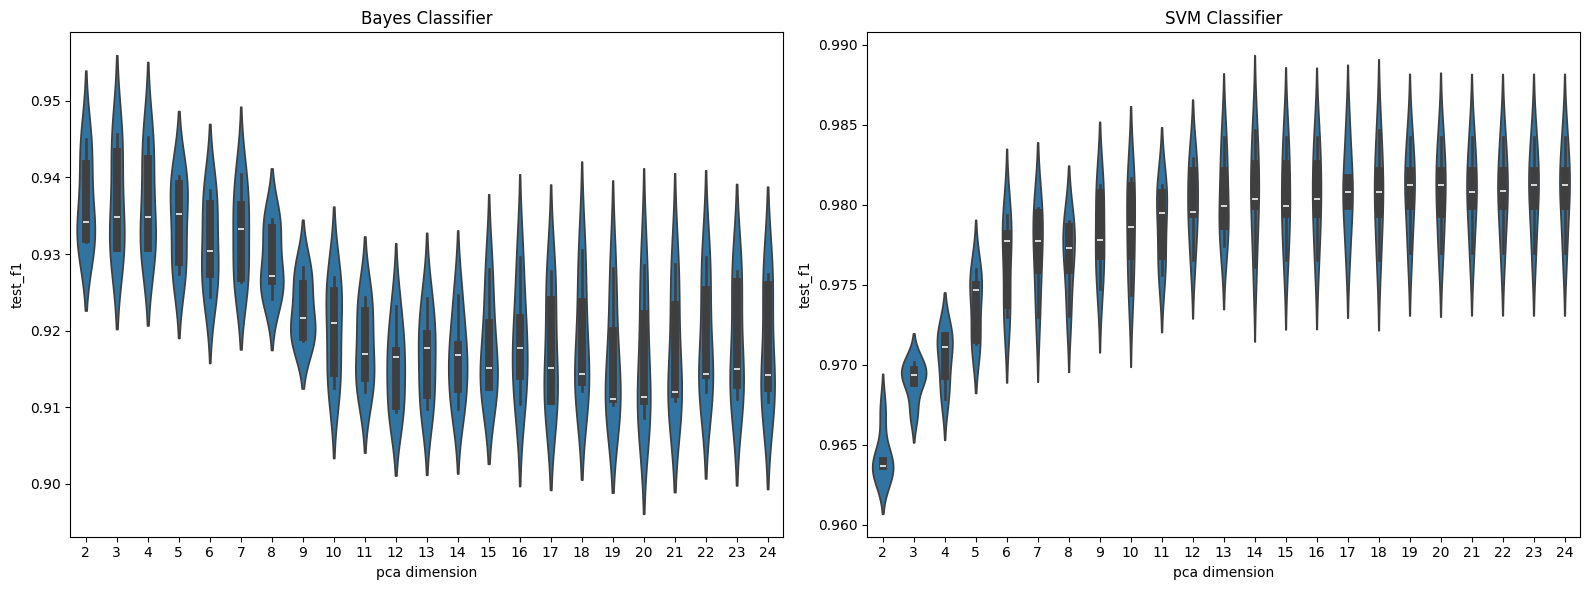

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.violinplot(ax=axes[0], data=df_bayes, y="test_f1", x="pca dimension")
axes[0].set_title('Bayes Classifier')

sns.violinplot(ax=axes[1], data=df_svm, y="test_f1", x="pca dimension")
axes[1].set_title('SVM Classifier')

plt.tight_layout()
plt.show()

comments:
- bayes performs better with lower dimension (this is because of assumption of independence and introducing more components introduces correlation)
- svm reaches best performance between 10 and 14 components, in PCA we saw that this components explain most of the variance.

### Impact of Feature Set and Classification Model

In [22]:
forward_set = ['min', 'skew', 'zero_crossings', 'abs_max', 'margin_factor', 'shape_factor',
 'theta_power', 'alpha_power', 'wavelet_energy_level_0',
 'wavelet_energy_level_2', 'wavelet_energy_level_4', 'approx_entropy']
backward_set = ['std', 'max', 'skew', 'rms', 'zero_crossings', 'abs_max', 'margin_factor',
 'shape_factor', 'delta_power', 'theta_power', 'alpha_power', 'gamma_power',
 'approx_entropy']
sep_corr_set = ['std','rms','abs_max','max','min','approx_entropy','margin_factor','crest_factor','gamma_power','delta_power']


config_forward = {
        'data_path': data_path,
        'target_column': target_column,
        'scaling': True,
        'feature_selection_method': 'naive',  # Use naive feature selection branch
        'feature_list': forward_set,
        'reduction_method': None,             # No dimensionality reduction
        'classifier_name': 'svm',             # Options: 'svm' or 'gnb'
        'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
        'cv_splits': 5,
        'random_state': 42
    }

config_pca = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     
    'feature_list': None,                   
    'reduction_method': 'pca',              
    'reduction_params': {'n_components': 10}, 
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},    'cv_splits': 5,
    'random_state': 42
    }



config_backward = config_forward.copy()
config_backward["feature_list"] = backward_set

config_sep_corr = config_forward.copy()
config_sep_corr["feature_list"] = sep_corr_set



pipeline_forward = TrainingPipeline(**config_forward)
results_forward = pipeline_forward.run()
results_forward["feature set"] = "forward"


pipeline_backward = TrainingPipeline(**config_backward)
results_backward = pipeline_backward.run()
results_backward["feature set"] = "backward"


pipeline_sep_corr = TrainingPipeline(**config_sep_corr)
results_sep_corr = pipeline_sep_corr.run()
results_sep_corr["feature set"] = "sep-corr"

pipeline_pca = TrainingPipeline(**config_pca)
results_pca = pipeline_pca.run()
results_pca["feature set"] = "PCA"

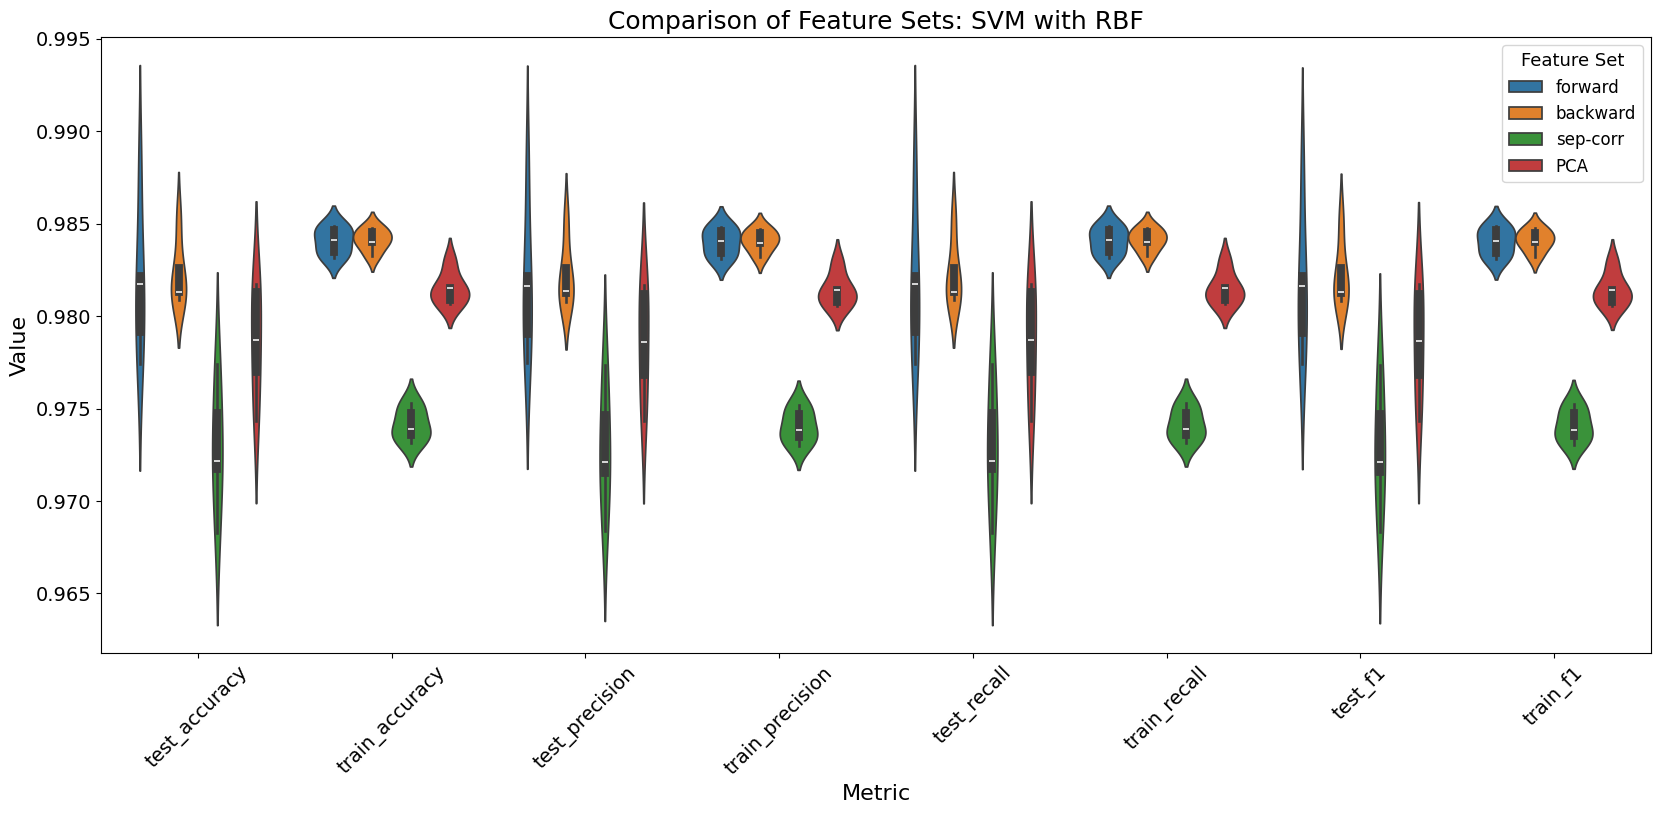

In [23]:
df = pd.concat([pd.DataFrame(results_forward), pd.DataFrame(results_backward), pd.DataFrame(results_sep_corr), pd.DataFrame(results_pca)], axis=0)
df.drop(columns=["fit_time","score_time","estimator"], inplace=True)

df_long = pd.melt(
    df, 
    id_vars=["feature set"],  
    var_name="Metric",        
    value_name="Value"        
)

plt.figure(figsize=(20, 8))
sns.violinplot(data=df_long, x="Metric", y="Value", hue="feature set")
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.title("Comparison of Feature Sets: SVM with RBF", fontsize=18)
plt.legend(title="Feature Set", title_fontsize='13', fontsize='12')
plt.show()

for SVC best feature sets are empiric forward and backward (inductive bias, this set was selectd by training with this specific model)

In [24]:
config_forward = {
        'data_path': data_path,
        'target_column': target_column,
        'scaling': True,
        'feature_selection_method': 'naive',  # Use naive feature selection branch
        'feature_list': forward_set,
        'reduction_method': None,             # No dimensionality reduction
        'classifier_name': 'gnb',             # Options: 'svm' or 'gnb'
        #'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
        'cv_splits': 5,
        'random_state': 42
    }

config_pca = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': None,     
    'feature_list': None,                   
    'reduction_method': 'pca',              
    'reduction_params': {'n_components': 2}, 
    'classifier_name': 'gnb',
    #'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},    'cv_splits': 5,
    'random_state': 42
    }



config_backward = config_forward.copy()
config_backward["feature_list"] = backward_set

config_sep_corr = config_forward.copy()
config_sep_corr["feature_list"] = sep_corr_set



pipeline_forward = TrainingPipeline(**config_forward)
results_forward = pipeline_forward.run()
results_forward["feature set"] = "forward"


pipeline_backward = TrainingPipeline(**config_backward)
results_backward = pipeline_backward.run()
results_backward["feature set"] = "backward"


pipeline_sep_corr = TrainingPipeline(**config_sep_corr)
results_sep_corr = pipeline_sep_corr.run()
results_sep_corr["feature set"] = "sep-corr"

pipeline_pca = TrainingPipeline(**config_pca)
results_pca = pipeline_pca.run()
results_pca["feature set"] = "PCA"

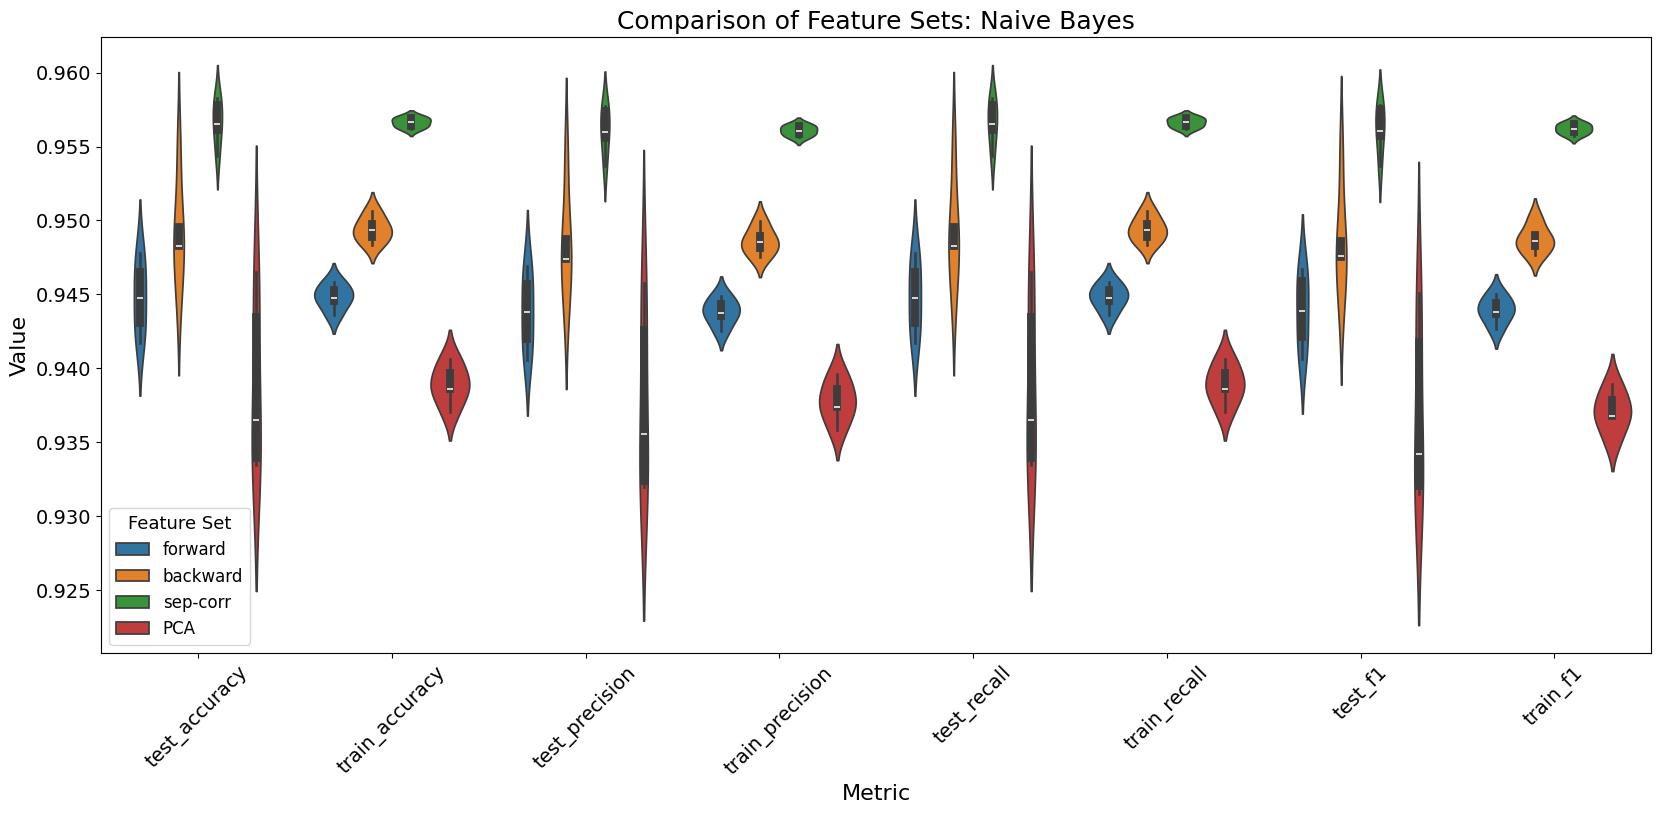

In [25]:
df = pd.concat([pd.DataFrame(results_forward), pd.DataFrame(results_backward), pd.DataFrame(results_sep_corr), pd.DataFrame(results_pca)], axis=0)
df.drop(columns=["fit_time","score_time","estimator"], inplace=True)

df_long = pd.melt(
    df, 
    id_vars=["feature set"],  
    var_name="Metric",        
    value_name="Value"        
)

plt.figure(figsize=(20, 8))
sns.violinplot(data=df_long, x="Metric", y="Value", hue="feature set")
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Metric", fontsize=16)
plt.ylabel("Value", fontsize=16)
plt.title("Comparison of Feature Sets: Naive Bayes", fontsize=18)
plt.legend(title="Feature Set", title_fontsize='13', fontsize='12')
plt.show()

When using Bayes the best feature set is the one that eliminates features according to correlation, this set generalizes better


## Conclusions from this Notebook
Results are very good in general, metrics above 0.95
Best model accordding to results:

**SUCIO** NO BORRAR ESTO, LO TENGO QUE PONER EN EL NOTEBOOK THE SELECCIÓN DE CARACTERÍSTICAS

In [ ]:
# Qué feature set utiliza el sequential???

sfs_parameters = {
    'n_features_to_select': "auto",
    'direction': 'forward',
    'cv': 4,
    'n_jobs': -1
}

config_sfs = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': 'sequential',  # Use sequential feature selection branch
    'feature_list': None,                      # Not needed here
    'sfs_params': sfs_parameters,              # Parameters for SequentialFeatureSelector
    'reduction_method': None,                  # No dimensionality reduction
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
}

pipeline_sfs = TrainingPipeline(**config_sfs)
results_sfs = pipeline_sfs.run()

In [ ]:
features = pd.read_csv("transformed_df.csv").drop(columns="y").columns

for pipeline in results_sfs["estimator"]:
    print(features[pipeline.named_steps["sequential_selector"].get_support()].values)

['min' 'skew' 'zero_crossings' 'abs_max' 'margin_factor' 'shape_factor'
 'theta_power' 'alpha_power' 'wavelet_energy_level_0'
 'wavelet_energy_level_2' 'wavelet_energy_level_4' 'approx_entropy']
['std' 'min' 'skew' 'zero_crossings' 'impulse_factor' 'delta_power'
 'theta_power' 'alpha_power' 'beta_power' 'gamma_power'
 'wavelet_energy_level_1' 'approx_entropy']
['mean' 'std' 'skew' 'zero_crossings' 'margin_factor' 'delta_power'
 'theta_power' 'alpha_power' 'gamma_power' 'wavelet_energy_level_1'
 'wavelet_energy_level_3' 'approx_entropy']
['std' 'min' 'max' 'skew' 'zero_crossings' 'margin_factor'
 'impulse_factor' 'delta_power' 'theta_power' 'alpha_power' 'beta_power'
 'approx_entropy']
['mean' 'std' 'max' 'skew' 'rms' 'zero_crossings' 'impulse_factor'
 'delta_power' 'theta_power' 'alpha_power' 'wavelet_energy_level_2'
 'approx_entropy']


C:\Users\rjvil\AppData\Local\Temp\ipykernel_12824\3007504566.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')


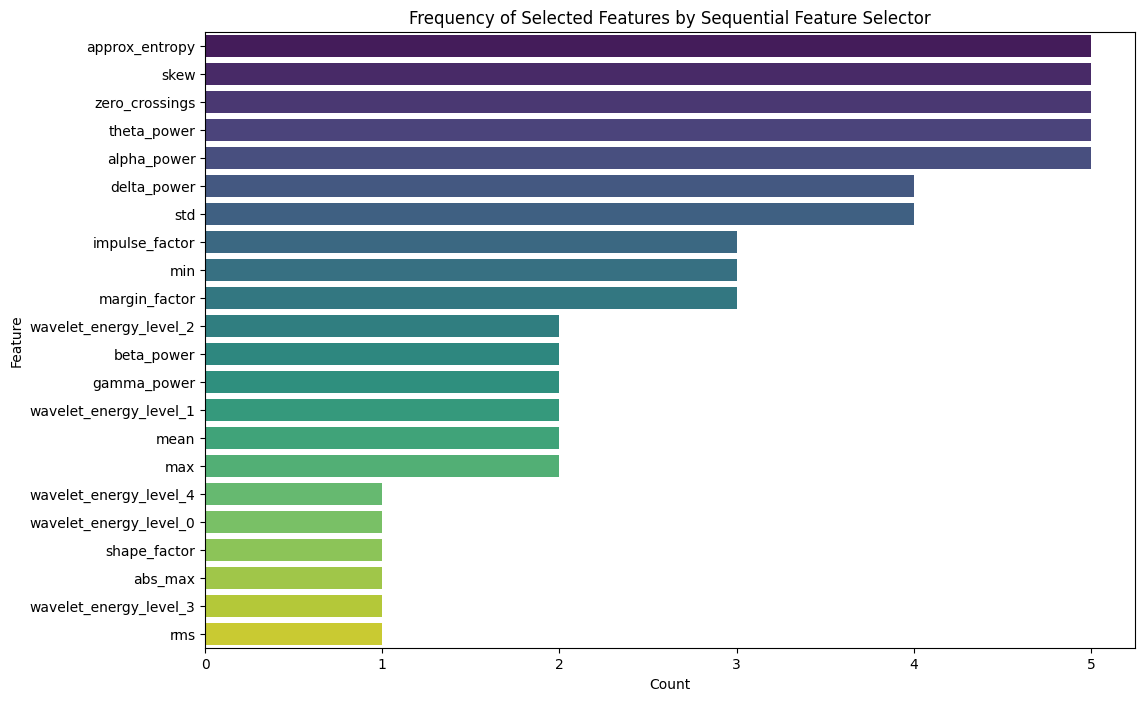

In [ ]:
from collections import Counter
selected_features = []
for pipeline in results_sfs["estimator"]:
    selected_features.extend(features[pipeline.named_steps["sequential_selector"].get_support()].values)

feature_counts = Counter(selected_features)

feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count']).reset_index()
feature_counts_df.rename(columns={'index': 'feature'}, inplace=True)
feature_counts_df.sort_values(by='count', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')
plt.title('Frequency of Selected Features by Sequential Feature Selector')
plt.xlabel('Count')
plt.ylabel('Feature')
plt.show()

In [ ]:
# Y hacia atrás qué features le gustan?

# Qué feature set utiliza el sequential???

sfs_parameters = {
    'n_features_to_select': "auto",
    'direction': 'backward',
    'cv': 4,
    'n_jobs': -1
}

config_sfs = {
    'data_path': data_path,
    'target_column': target_column,
    'scaling': True,
    'feature_selection_method': 'sequential',  # Use sequential feature selection branch
    'feature_list': None,                      # Not needed here
    'sfs_params': sfs_parameters,              # Parameters for SequentialFeatureSelector
    'reduction_method': None,                  # No dimensionality reduction
    'classifier_name': 'svm',
    'classifier_params': {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
    'cv_splits': 5,
    'random_state': 42
}

pipeline_sfs = TrainingPipeline(**config_sfs)
results_sfs = pipeline_sfs.run()


In [ ]:
features = pd.read_csv("transformed_df.csv").drop(columns="y").columns

for pipeline in results_sfs["estimator"]:
    print(features[pipeline.named_steps["sequential_selector"].get_support()].values)

['std' 'max' 'skew' 'rms' 'zero_crossings' 'abs_max' 'margin_factor'
 'shape_factor' 'delta_power' 'theta_power' 'alpha_power' 'gamma_power'
 'approx_entropy']
['mean' 'skew' 'kurtosis' 'zero_crossings' 'abs_max' 'margin_factor'
 'shape_factor' 'theta_power' 'alpha_power' 'gamma_power'
 'wavelet_energy_level_1' 'wavelet_energy_level_4' 'approx_entropy']
['mean' 'skew' 'kurtosis' 'rms' 'zero_crossings' 'abs_max' 'margin_factor'
 'shape_factor' 'theta_power' 'alpha_power' 'gamma_power'
 'wavelet_energy_level_4' 'approx_entropy']
['std' 'min' 'max' 'skew' 'rms' 'zero_crossings' 'margin_factor'
 'shape_factor' 'delta_power' 'theta_power' 'alpha_power'
 'wavelet_energy_level_1' 'approx_entropy']
['mean' 'min' 'skew' 'kurtosis' 'rms' 'zero_crossings' 'margin_factor'
 'delta_power' 'theta_power' 'alpha_power' 'wavelet_energy_level_1'
 'wavelet_energy_level_3' 'approx_entropy']


C:\Users\rjvil\AppData\Local\Temp\ipykernel_12824\3007504566.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')


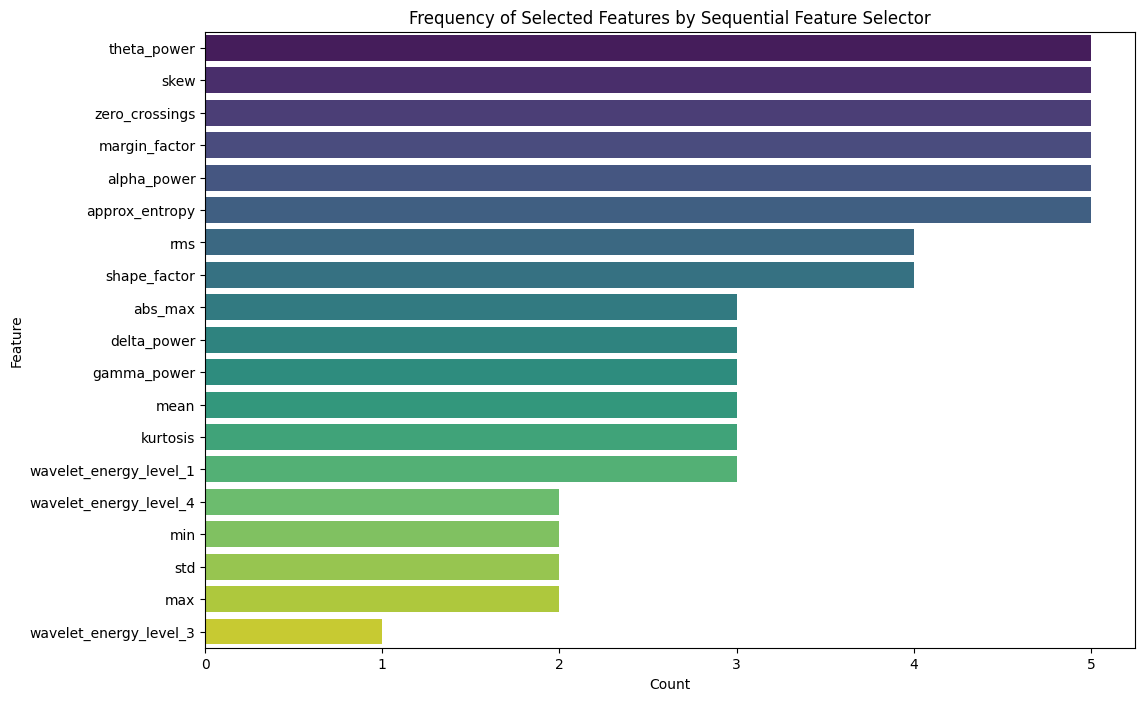

In [ ]:
from collections import Counter
selected_features = []
for pipeline in results_sfs["estimator"]:
    selected_features.extend(features[pipeline.named_steps["sequential_selector"].get_support()].values)

feature_counts = Counter(selected_features)

feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient='index', columns=['count']).reset_index()
feature_counts_df.rename(columns={'index': 'feature'}, inplace=True)
feature_counts_df.sort_values(by='count', ascending=False, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_counts_df, x='count', y='feature', palette='viridis')
plt.title('Frequency of Selected Features by Sequential Feature Selector')
plt.xlabel('Count')
plt.ylabel('Feature')
plt.show()

Seems like backward selection algorithm yields similar results. Maybe contrast with feature importance.